In [170]:
import pandas as pd
import numpy as np
import pickle
import gc
import hyperdash as hd
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#'store_nbr', 'n_city', 'n_state', 'n_type', 'cluster', 'item_nbr', 'n_family', 'class', 'perishable'

In [2]:
unit_mean, unit_std = pd.read_csv('data/mean_std.csv', index_col=0).T[0]

In [3]:
df_stores = pd.read_csv(
    'data/num_stores.csv.gz',
     dtype={
         'store_nbr': np.uint8,
         'n_city': np.uint8,
         'n_state': np.uint8,
         'n_type': np.uint8,
         'cluster': np.uint8
     }

)
df_items = pd.read_csv(
    'data/num_items.csv.gz',
    dtype={
        'item_nbr': np.int32,
        'n_family': np.uint8,
        'class': np.int16,
        'perishable': np.int8,
    }
)
for stores_col in ['n_city', 'n_state', 'n_type', 'cluster']:
    df_stores[stores_col] = df_stores[stores_col] - df_stores[stores_col].min()
    
for items_col in ['n_family', 'class', 'perishable']:
    df_items[items_col] = df_items[items_col] - df_items[items_col].min()

In [4]:
%%time
df = pd.read_csv(
    'data/ts.csv.gz',
    parse_dates=[0],
    #nrows=1000000,
    dtype={
        'item_nbr': np.int32,
        'store_nbr': np.int8,
        'unit_sales': np.float32,
        'onpromotion': np.int8,
        'holiday': np.int8,
        'weekend': np.int8,
        'waged_day': np.int8,
        'dow_0': np.int8,
        'dow_1': np.int8,
        'dow_2': np.int8,
        'dow_3': np.int8,
        'dow_4': np.int8,
        'dow_5': np.int8,
        'dow_6': np.int8,
    }
)
df.head()

CPU times: user 5min 50s, sys: 14.1 s, total: 6min 4s
Wall time: 5min 25s


In [211]:
%%time
sales_min = df['unit_sales_scaled'].min()
sales_max = df['unit_sales_scaled'].max()
nbins = 100
bins = np.arange(sales_min, sales_max, (sales_max - sales_min)/nbins)
df['unit_sales_scaled_class'] = np.digitize(df['unit_sales_scaled'], bins)

bins = np.arange(sales_min, sales_max+step, step)
bin_hist = np.histogram(df['unit_sales_scaled'], bins)
bin_hist = bin_hist[0][bin_hist[0] != 0]
bin_weights = np.sqrt(bin_hist) / bin_hist

oh_enc = LabelBinarizer()
oh_enc.fit(df['unit_sales_scaled_class'])

/home/dmitry/miniconda3/envs/tf_intel/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 58.6 s, sys: 26.2 s, total: 1min 24s
Wall time: 37.2 s


In [6]:
df.head()

,date,store_nbr,item_nbr,unit_sales_scaled,onpromotion,holiday,weekend,waged_day,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,unit_sales_scaled_class
0,2015-06-01,1,96995,-0.716897,0,0,0,0,1,0,0,0,0,0,0,1
1,2015-06-02,1,96995,-0.716897,0,0,0,0,0,1,0,0,0,0,0,1
2,2015-06-03,1,96995,-0.716897,0,0,0,0,0,0,1,0,0,0,0,1
3,2015-06-04,1,96995,-0.716897,0,0,0,0,0,0,0,1,0,0,0,1
4,2015-06-05,1,96995,-0.716897,0,0,0,0,0,0,0,0,1,0,0,1


In [7]:
%%time
#ts_columns = df.columns[3:]
ts_columns = [
    'unit_sales_scaled', 'unit_sales_scaled_class',
    'onpromotion','holiday', 'weekend', 'waged_day',
    'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6'
]

ts_columns_wo_class = [
    'unit_sales_scaled',
    'onpromotion','holiday', 'weekend', 'waged_day',
    'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6'
]

attr_cols = [
    'store_nbr', 'n_city', 'n_state', 'n_type', 'cluster',
    'item_nbr', 'n_family', 'class',
    #'perishable'
]

df_pivot = df.pivot_table(
    index=['store_nbr', 'item_nbr'],
    columns=['date'],
    values=ts_columns
).reset_index()

df_pivot = df_pivot.merge(df_items, on='item_nbr')
df_pivot['store_nbr'] = df_pivot[('store_nbr', '')]
df_pivot = df_pivot.merge(df_stores, on='store_nbr')

/home/dmitry/miniconda3/envs/tf_intel/lib/python3.5/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


CPU times: user 15min 35s, sys: 3min 42s, total: 19min 17s
Wall time: 14min 39s


In [8]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210654 entries, 0 to 210653
Columns: 10710 entries, item_nbr to cluster
dtypes: float64(823), int16(1), int64(827), int8(9054), uint8(5)
memory usage: 4.4 GB


In [115]:
def get_date_cols(date, history=20, predict_days=16, ts_columns=ts_columns_wo_class, skip=0):
                  #date, days=1, attr_cols=attr_columns_wo_means, ts_cols=ts_columns, attr=True):
    
    if type(date) != pd.Timestamp:
        date = pd.to_datetime(date)
        
    X_start_date = date - pd.Timedelta('{} days'.format(history-1))
    #X_end_date = date
    y_start_date = date + pd.Timedelta('{} days'.format(skip+1))
    #y_end_date = date + pd.Timedelta('{} days'.format(predict_days))

    X_cols, y_cols_class, y_cols_values, y_cols_day_attr  = [], [], [], []
    
    for d in pd.date_range(X_start_date, periods=history, freq='D'):
        for elem in ts_columns:
            X_cols.append((elem, d))
            
    for d in pd.date_range(y_start_date, periods=predict_days, freq='D'):
        y_cols_class.append(('unit_sales_scaled_class', d))
        y_cols_values.append(('unit_sales_scaled', d))
        for elem in ts_columns[1:]:
            y_cols_day_attr.append((elem, d))
            
    return X_cols, y_cols_class, y_cols_values, y_cols_day_attr



X_cols, y_cols_class, y_cols_values, y_cols_day_attr = get_date_cols('2017-08-15', predict_days=5)
    
df_pivot.head().loc[:, y_cols_class]

,"(unit_sales_scaled_class, 2017-08-16 00:00:00)","(unit_sales_scaled_class, 2017-08-17 00:00:00)","(unit_sales_scaled_class, 2017-08-18 00:00:00)","(unit_sales_scaled_class, 2017-08-19 00:00:00)","(unit_sales_scaled_class, 2017-08-20 00:00:00)"
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1


In [123]:
def get_random_train_test(df_pivot, oh_enc,
        date, window=21, freq=7, size=2000, history=1, predict_days=16, epochs=2, 
        shuffle_dates=True, shuffle_indexes=True, attr_cols=attr_cols, ts_columns=ts_columns_wo_class, skip=0):
    
    
    window = freq * (window//freq)
    num_items = df_pivot.shape[0]
    
    date = pd.to_datetime(date)
    start_window =  date - pd.Timedelta('{} days'.format(window))
    end_date = date
    
    dates = pd.date_range(start=start_window, end=end_date)
    dates = dates[::freq]
    
    print(dates)
    
    patches = []
    #end_X_date = end_date - pd.Timedelta('{} days'.format(label_dates))
    if shuffle_dates and shuffle_indexes:
        permutated_dates = np.random.permutation(dates)
        permutated_indx = np.random.permutation(num_items)   
        for epoch in range(epochs):
            for i in range(num_items//size+1):
                s = size * i
                e = size * (i+1)
                indexes = permutated_indx[s:e]

                for date in permutated_dates:
                    patches.append([indexes, date])

        patches = np.random.permutation(patches)
        
    elif not shuffle_dates and shuffle_indexes:
        permutated_indx = np.random.permutation(num_items)
        for date in dates:
            for epoch in range(epochs):
                for i in range(num_items//size+1):
                    s = size * i
                    e = size * (i+1)
                    indexes = permutated_indx[s:e]
                    patches.append([indexes, date])

    for indexes, date in patches:
        df_pivot_slice = df_pivot.iloc[indexes]
        X_cols, y_cols_class, _y_cols, y_day_attr_cols = get_date_cols(
            date, history=history, predict_days=predict_days, ts_columns=ts_columns, skip=skip
        )

        X = np.array(
            df_pivot_slice.loc[:, X_cols]
        ).reshape([-1, history, len(ts_columns)])

        y_day_attr = np.array(
            df_pivot_slice.loc[:, y_day_attr_cols]
        ).reshape([-1, predict_days, len(ts_columns)-1])
        
        
        y = np.array(df_pivot_slice.loc[:, y_cols_class])
        y_dim1, y_dim2 = y.shape
        y = np.reshape(y, -1)

        y = oh_enc.transform(y)
        y = np.reshape(y, [y_dim1, y_dim2, -1])

        features = [X, y_day_attr, y]
        for feature in attr_cols:
            features.append(
                np.array(df_pivot_slice.loc[:, feature])
            )
        for i in range(len(indexes)):
            yield tuple([elem[i] for elem in features])

tmp = get_random_train_test(df_pivot, oh_enc, '2017-07-15', window=20, history=90, predict_days=5)
tmp1 = next(tmp)
print(tmp1[0].shape, tmp1[1].shape, tmp1[2].shape, tmp1[3].shape)

DatetimeIndex(['2017-07-01', '2017-07-08', '2017-07-15'], dtype='datetime64[ns]', freq='7D')
(90, 12) (5, 11) (5, 97) ()


In [86]:
print(oh_enc.inverse_transform( tmp1[2]))
a2 = np.array([tmp1[2], tmp1[2]])

def from_oh_to_values(df, oh_enc, sales_max, sales_min, nbins):
    d1, d2, d3 = df.shape

    values = ((
        oh_enc.inverse_transform(
            np.reshape(df, [d1*d2, d3])
        ) - 1)
    )*(sales_max - sales_min)/nbins + sales_min

    return np.reshape(values, [d1, d2])

from_oh_to_values(a2, oh_enc, sales_max, sales_min, nbins)

[31 25 26  1 21]


array([[ 2.2818955 ,  1.68213694,  1.7820967 , -0.71689729,  1.2822979 ],
       [ 2.2818955 ,  1.68213694,  1.7820967 , -0.71689729,  1.2822979 ]])

In [122]:
def get_validation(df_pivot, 
        date, history=1, predict_days=16, attr_cols=attr_cols, ts_columns=ts_columns_wo_class, skip=0):
    
    X_cols, y_cols_class, y_cols, y_day_attr_cols = get_date_cols(
        date, history=history, predict_days=predict_days, ts_columns=ts_columns, skip=skip
    )

    X = np.array(
        df_pivot.loc[:, X_cols]
    ).reshape([-1, history, len(ts_columns)])
    
    y_day_attr = np.array(
        df_pivot.loc[:, y_day_attr_cols]
    ).reshape([-1, predict_days, len(ts_columns)-1])

    y = np.array(df_pivot.loc[:, y_cols_class])
    
    y_dim1, y_dim2 = y.shape
    y = np.reshape(y, -1)

    y = oh_enc.transform(y)
    y = np.reshape(y, [y_dim1, y_dim2, -1])
        
    y_val = np.array(df_pivot.loc[:, y_cols])
    
    features = [X, y_day_attr, y, y_val]
    for feature in attr_cols:
        features.append(
            np.array(df_pivot.loc[:, feature])
        )

    return features

tmp = get_validation(df_pivot, '2017-07-15', history=90, predict_days=5)
print(tmp[0].shape, tmp[1].shape, tmp[2].shape, tmp[3].shape)

(210654, 90, 12) (210654, 5, 11) (210654, 5, 97) (210654, 5)


In [ ]:
%autoreload 2


try:
    hd_exp.end()
except NameError:
    pass


history = 400
time_to_predict = 16
freq=1

last_day_train = '2017-07-14'
window=300
epochs = 100
validation_day = pd.to_datetime(last_day_train) + pd.Timedelta('{} days'.format(time_to_predict))
batch_size = 2000
sum_W = 3574368.0/16
skip=0

print(validation_day)

batch_gen = get_random_train_test(
    df_pivot,
    oh_enc,
    last_day_train,
    window=window,
    history=history,
    size=batch_size,
    predict_days=time_to_predict,
    epochs=epochs,
    skip=skip,
    freq=freq
)

val_set = get_validation(df_pivot, validation_day, history=history,
                        predict_days=time_to_predict, skip=skip)

from model import RNNModel

m = RNNModel(
    history=history,
    n_days_predict=time_to_predict,
    n_classes=len(oh_enc.classes_),
    clip_gradients=5.,
    starter_learning_rate=0.0001,
    #starter_learning_rate=0.0005,
    n_layers_rnn=1,
    rnn_size_encoder=200,
    rnn_size_decoder=200,
    bin_weights=bin_weights,
)
print(1)
m.build_graph(batch_gen)

print(2)
hd_exp = hd.Experiment('RNN fav 4')


tmp = m.train(
    val_set, coef=unit_std, sum_W=sum_W,
    oh_enc=oh_enc, sales_max=sales_max,
    sales_min=sales_min, nbins=nbins,
    report_every=100, validate_every=1000,
    hd_exp=hd_exp
)


2017-07-30 00:00:00
1
2
DatetimeIndex(['2016-09-17', '2016-09-18', '2016-09-19', '2016-09-20',
               '2016-09-21', '2016-09-22', '2016-09-23', '2016-09-24',
               '2016-09-25', '2016-09-26',
               ...
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14'],
              dtype='datetime64[ns]', length=301, freq='D')
g_step: 100 loss std/mean: 0.014868911355733871 4.670734405517578
| Loss std:   0.014869 |
| Loss mean:   4.670734 |
g_step: 200 loss std/mean: 0.01053551584482193 4.651306629180908
| Loss std:   0.010536 |
| Loss mean:   4.651307 |
g_step: 300 loss std/mean: 0.011452400125563145 4.635562896728516
| Loss std:   0.011452 |
| Loss mean:   4.635563 |
g_step: 400 loss std/mean: 0.009527635760605335 4.627514839172363
| Loss std:   0.009528 |
| Loss mean:   4.627515 |
g_step: 500 loss std/mean: 0.008258952759206295 4.617305755

In [165]:
tmp1 = from_oh_to_values(predicted1, oh_enc, sales_max, sales_min, nbins).reshape(-1)

In [167]:
np.unique(tmp1)

array([-0.71689729])

In [ ]:
Validation NWRMSLE  : 1.34526972891
Validation NWRMSLE_5: 1.36811241721

array([-0.71689729, -0.61693753, -0.51697777, -0.41701801, -0.31705825,
       -0.21709849, -0.11713873, -0.01717898,  0.08278078,  0.18274054,
        0.2827003 ,  0.38266006,  0.48261982,  0.58257958,  0.68253934,
        0.7824991 ,  0.88245886,  0.98241862,  1.08237838,  1.18233814,
        1.2822979 ,  1.38225766,  1.48221742,  1.58217718,  1.68213694,
        1.7820967 ,  1.88205646,  1.98201622,  2.08197598,  2.18193574,
        2.2818955 ,  2.38185526,  2.48181502,  2.58177478,  2.68173454,
        2.7816943 ,  2.88165406,  2.98161382,  3.08157358,  3.18153334,
        3.2814931 ,  3.38145286,  3.48141262,  3.58137237,  3.68133213,
        3.78129189,  3.88125165,  3.98121141,  4.08117117,  4.18113093,
        4.28109069,  4.38105045,  4.48101021,  4.58096997,  4.68092973,
        4.78088949,  4.88084925,  4.98080901,  5.08076877,  5.18072853,
        5.28068829,  5.38064805,  5.48060781,  5.58056757,  5.68052733,
        5.78048709,  5.88044685,  5.98040661,  6.08036637,  6.18

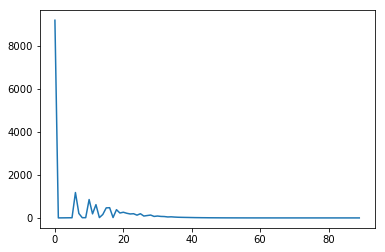

In [204]:
plt.plot(tmp2[0]/np.exp(bins[-1:]))

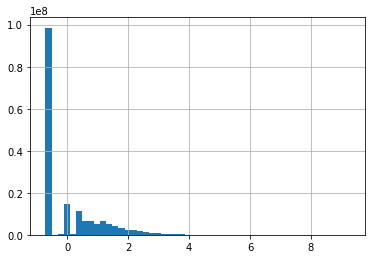

In [173]:
df['unit_sales_scaled'].hist(bins=50)
plt.show()

In [187]:
sales_min = df['unit_sales_scaled'].min()
sales_max = df['unit_sales_scaled'].max()
nbins = 100
bins = np.arange(sales_min, sales_max, (sales_max - sales_min)/nbins)
df['unit_sales_scaled_class'] = np.digitize(df['unit_sales_scaled'], bins)

In [184]:
np.unique(tmp).shape

(188,)

In [175]:
print(df['unit_sales_scaled'].min(), df['unit_sales_scaled'].max())

-0.716897293213 9.27907867893


In [31]:
sales = df[
    (df['item_nbr'] == 1503844) &
    (df['store_nbr'] == 44) 
    
]['unit_sales_scaled']

In [34]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

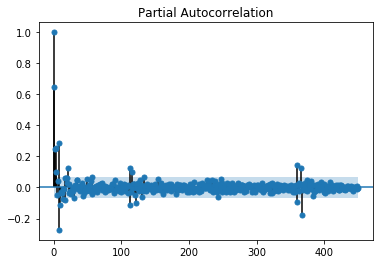

In [33]:
sm.graphics.tsa.plot_pacf(sales, lags=450)
plt.show()

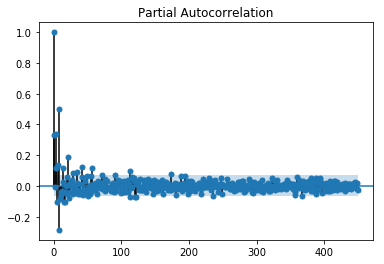

In [49]:
sales2, tmp = stats.boxcox((sales+unit_mean))
sm.graphics.tsa.plot_pacf(sales2, lags=450)
plt.show()

In [160]:
df['date'].max() - pd.Timedelta('{} days'.format(16+400+300)) - df['date'].min()

Timedelta('106 days 00:00:00')